In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['sample_submission.csv', 'plates.zip']
After zip extraction:
['train', 'test', 'val', '__notebook_source__.ipynb', '__MACOSX', 'plates', 'submission.csv']


In [3]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['train', 'test', '.DS_Store']


In [4]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 3302.85it/s]


In [5]:
!ls train

cleaned  dirty


In [6]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
        transforms.RandomChoice([transforms.CenterCrop(180),
                                 transforms.CenterCrop(160),
                                 transforms.CenterCrop(140),
                                 transforms.CenterCrop(120),
                                 transforms.Compose([transforms.CenterCrop(280),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(200),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
        transforms.Resize((224, 224)),
        transforms.ColorJitter(hue=(0.1,0.2)), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

val_transforms = transforms.Compose([
        transforms.RandomChoice([transforms.CenterCrop(180),
                                 transforms.CenterCrop(160),
                                 transforms.CenterCrop(140),
                                 transforms.CenterCrop(120),
                                 transforms.Compose([transforms.CenterCrop(280),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(200),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
        transforms.Resize((224, 224)),
        transforms.ColorJitter(hue=(0.1,0.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [7]:
len(train_dataloader), len(train_dataset)

(4, 32)

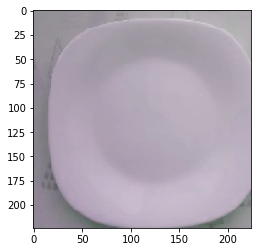

In [8]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

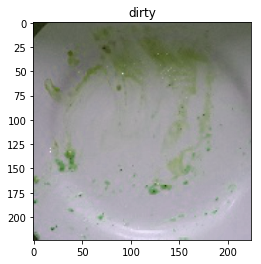

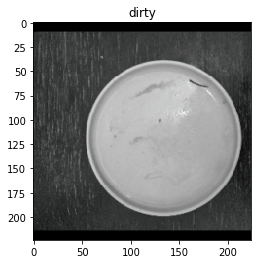

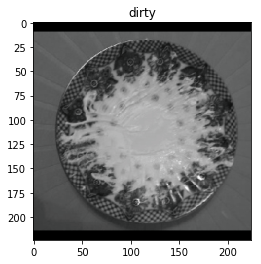

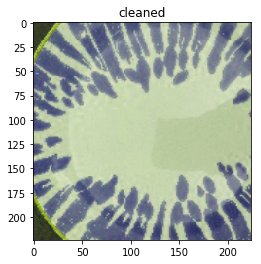

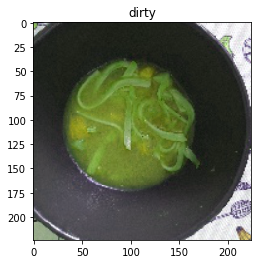

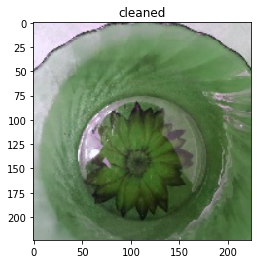

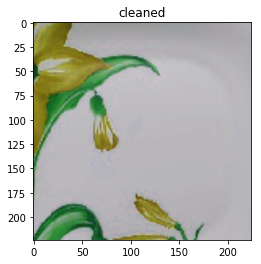

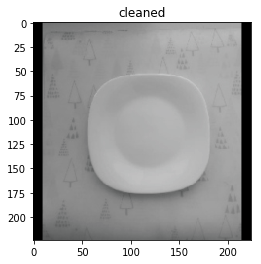

In [9]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

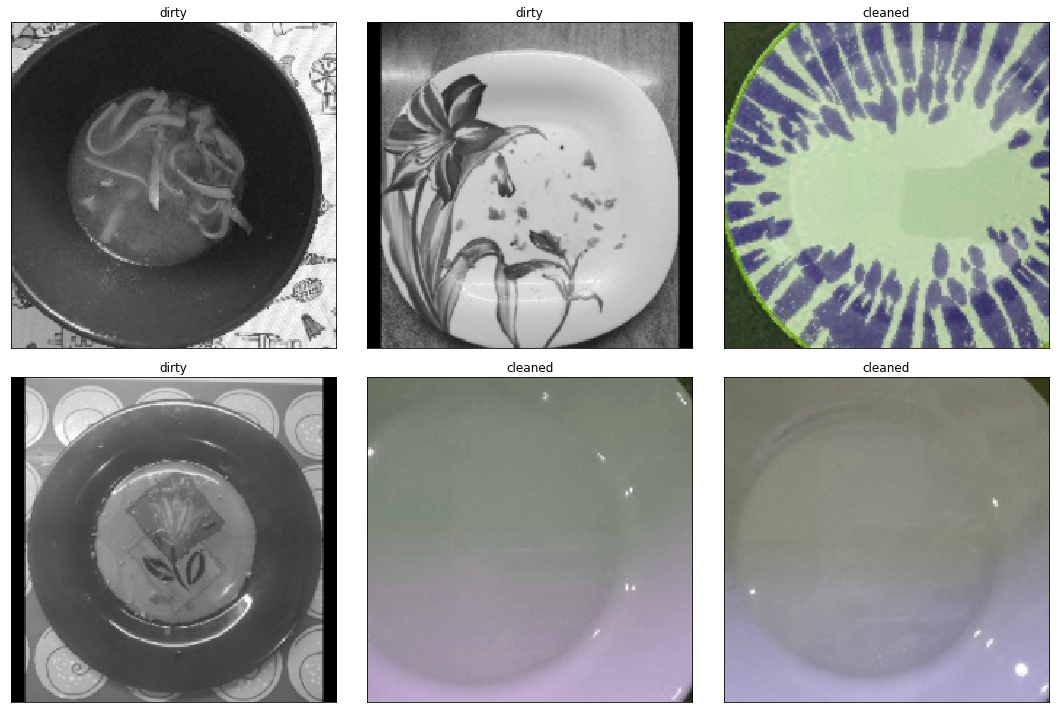

In [10]:
def show_image(dataloader):
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    X_batch, y_batch = next(iter(dataloader))
    
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))

    for x_item, y_item, i, j in zip(X_batch, y_batch, [0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]):
    
        image = x_item.permute(1, 2, 0).numpy()
        image = std * image + mean
        
        ax[i, j].imshow(image.clip(0, 1))
        ax[i, j].set_title(class_names[y_item])

        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

    fig.tight_layout()
    plt.show()

show_image(train_dataloader)

In [11]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
 
    loss_hist = {'train':[], 'val':[]}
    acc_hist = {'train':[], 'val':[]}
 
    for epoch in range(num_epochs):
        print("Epoch {}/{}:".format(epoch, num_epochs - 1), end="")
        for phase in ['train', 'val']:
            if phase == 'train': #Если фаза == Тренировки  
                dataloader = train_dataloader #берем train_dataLoader
                scheduler.step() #Делаем 1 шаг (произошла одна эпоха)
                model.train()  # Модель в training mode - обучение (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
            else: #Если фаза == Валидации 
                dataloader = val_dataloader #берем val_dataLoader 
                model.eval()   # Модель в evaluate mode - валидация (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
 
            running_loss = 0. 
            running_acc = 0.
 
            # Итерируемся по dataloader
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device) # Тензор с изображениями переводим на GPU 
                labels = labels.to(device) # Тензор с лейблами переводим на GPU 
 
                optimizer.zero_grad() # Обнуляем градиент,чтобы он не накапливался 
 
                with torch.set_grad_enabled(phase == 'train'): #Если фаза train то активируем все градиенты (те которые не заморожены) (очистить историю loss)
                    preds = model(inputs) # Считаем предикты, input передаем в модель
                    loss_value = loss(preds, labels) #Посчитали  Loss    
                    preds_class = preds.argmax(dim=1) # Получаем класс,берем .argmax(dim=1) нейрон с максимальной активацией
                
                    if phase == 'train':
                        loss_value.backward() # Считаем градиент 
                        optimizer.step() # Считаем шаг градиентного спуска
 
                # Статистика
                running_loss += loss_value.item() #считаем Loss
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()  #считаем accuracy
 
            epoch_loss = running_loss / len(dataloader)  # Loss'ы делим на кол-во бачей в эпохе 
            epoch_acc = running_acc / len(dataloader) #считаем Loss на кол-во бачей в эпохе
 
            print("{} Loss: {:.4f} Acc: {:.4f} ".format(phase, epoch_loss, epoch_acc), end="")
            
            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)
        
    return model, loss_hist, acc_hist

In [15]:
import random
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

model = models.resnet152(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False
    
model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=1.0)
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
model, loss, acc = train_model(model, loss, optimizer, scheduler, num_epochs=30);

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7722 Acc: 0.4375 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.6573 Acc: 0.5000 Epoch 1/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6245 Acc: 0.6875 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.5904 Acc: 0.7500 Epoch 2/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6034 Acc: 0.5938 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.5258 Acc: 0.8750 Epoch 3/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.4981 Acc: 0.8125 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.5945 Acc: 0.7500 Epoch 4/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.6021 Acc: 0.6875 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.5746 Acc: 0.7500 Epoch 5/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.4101 Acc: 0.8750 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.4556 Acc: 0.8750 Epoch 6/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.3665 Acc: 0.9375 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.5219 Acc: 0.7500 Epoch 7/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.3912 Acc: 0.8750 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.4679 Acc: 0.7500 Epoch 8/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.3388 Acc: 0.9375 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.5160 Acc: 0.6250 Epoch 9/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.3487 Acc: 1.0000 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.5707 Acc: 0.6250 Epoch 10/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.4440 Acc: 0.8750 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.4998 Acc: 0.7500 Epoch 11/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.3750 Acc: 0.9062 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.4825 Acc: 0.7500 Epoch 12/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.4404 Acc: 0.9062 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.5621 Acc: 0.6250 Epoch 13/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.3959 Acc: 0.8438 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.4205 Acc: 0.7500 Epoch 14/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.3814 Acc: 0.9062 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.4010 Acc: 0.8750 Epoch 15/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.3979 Acc: 0.9062 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.4142 Acc: 0.8750 Epoch 16/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.3675 Acc: 0.8438 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.4571 Acc: 0.8750 Epoch 17/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.3674 Acc: 0.8750 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.5373 Acc: 0.7500 Epoch 18/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.3123 Acc: 0.9375 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.5289 Acc: 0.7500 Epoch 19/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.3771 Acc: 0.9062 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.4534 Acc: 0.8750 Epoch 20/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.4361 Acc: 0.8438 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.3792 Acc: 0.8750 Epoch 21/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.4254 Acc: 0.9062 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.4692 Acc: 0.8750 Epoch 22/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.3354 Acc: 0.9375 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.4713 Acc: 0.8750 Epoch 23/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.4133 Acc: 0.9062 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.4918 Acc: 0.8750 Epoch 24/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.4212 Acc: 0.8438 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.4438 Acc: 0.8750 Epoch 25/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.4123 Acc: 0.8750 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.4762 Acc: 0.8750 Epoch 26/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.3704 Acc: 0.9062 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.4953 Acc: 0.7500 Epoch 27/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.4357 Acc: 0.8125 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.5036 Acc: 0.8750 Epoch 28/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.4047 Acc: 0.8750 

  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.4433 Acc: 0.7500 Epoch 29/29:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.3618 Acc: 0.9375 

100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

val Loss: 0.5448 Acc: 0.7500 

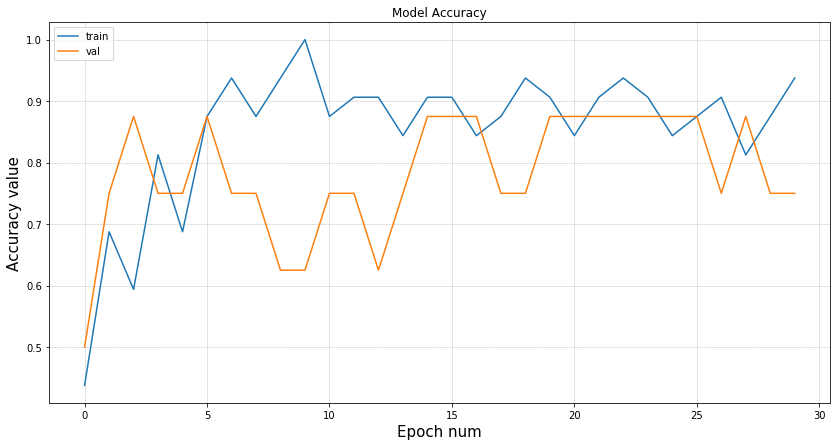

In [17]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

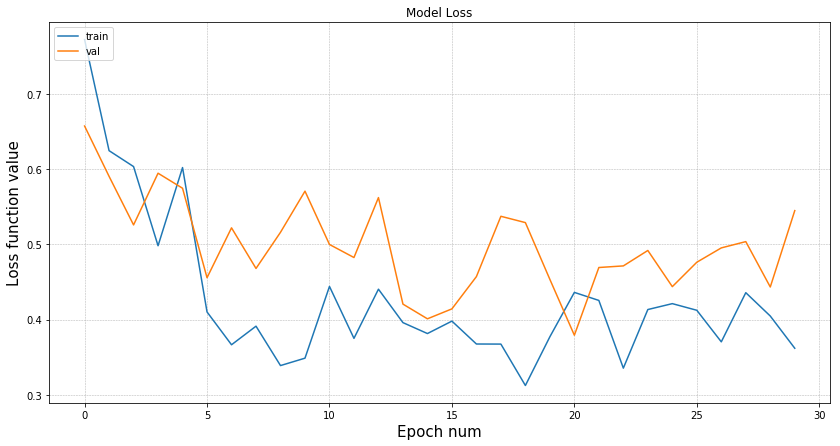

In [18]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss.keys():
    plt.plot(loss[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')

In [20]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [21]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [22]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:10<00:00,  9.29it/s]


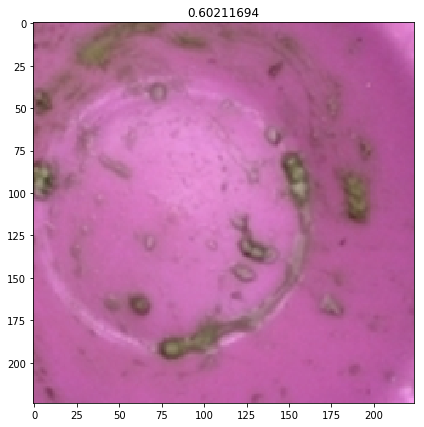

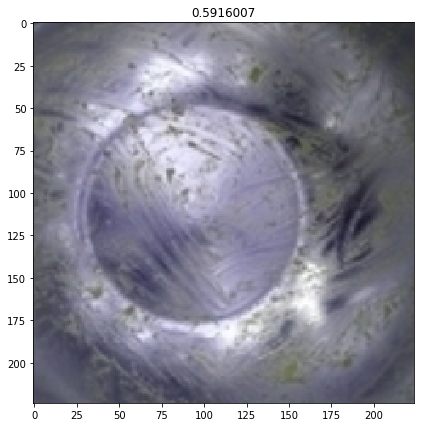

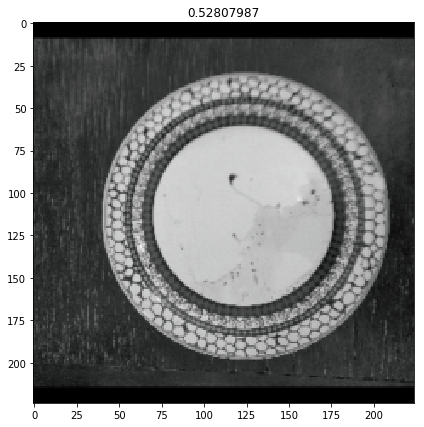

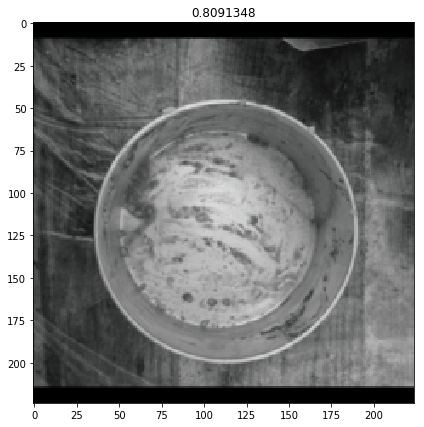

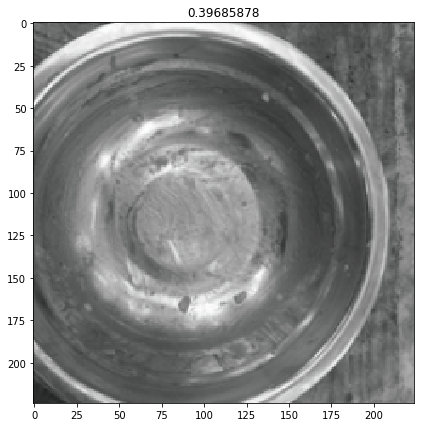

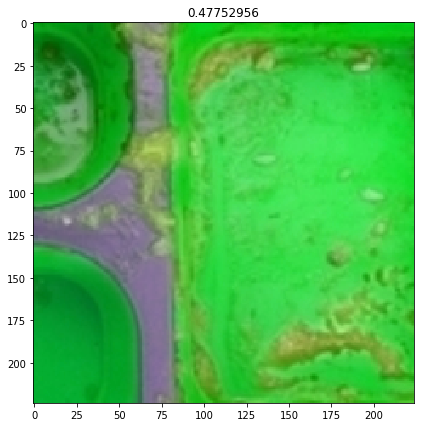

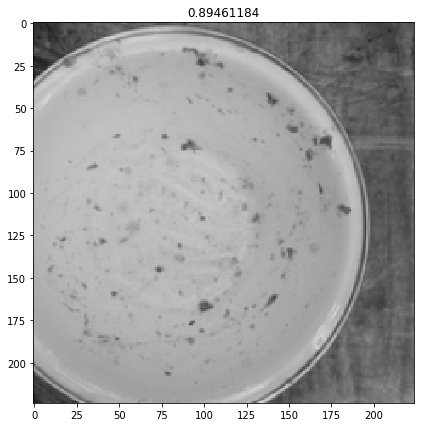

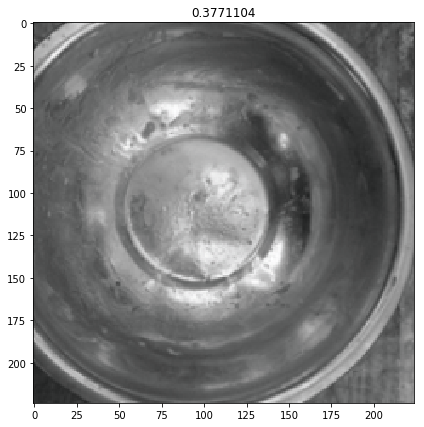

In [23]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [24]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [25]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,cleaned
0005,cleaned


In [26]:
submission_df.to_csv('submission.csv')

In [27]:
!rm -rf train val test

In [28]:
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv